# Project 4: Static Information Flow Analysis using Hoare logic in and for Python

Author: Daniel Gusenburger

Student ID: 2544941

**Note**: My teammate dropped out before we/I started with this project and after the teams had been fixed so I had to it as a single person project.

## What is this ?

This project was partly inspired by the _Program Analysis_ lecture by Prof. Dr. Jan Reineke from Saarland University as well as the chapter on ["Tracking Failure Origins"](https://www.debuggingbook.org/html/Slicer.html) from [The Debugging Book](https://www.debuggingbook.org/).
The goal of this project was to create a plugin for Flake8 to statically analyse
your code and find dependencies between variables deemed _confidential_ or
_inconfidential_ (high/low in terms of security classes) by the user.

In the following code for example, we don't want any information about the
variable `high` to be leaked to the public. We furthermore have a variable `low`
that is available to the public. Note, that for Python specifically, this may
be less feasible as the inspection of variables is far easier than it is for
compiled languages like C. 

```python
def foo(high, low): # flow: High, Low
    if high > 10:
        low = 10
    else:
        low = 0
    return low
```

Since high is a high confidentiality variable, we assume that the public does
not know anything about this variable. In the example function however, we have
an interaction between a publically accessible variable and a confidential
variable. The public variable is modified depending on the context of the
confidential variable and thus leaks information about the confidential
variable.

Using Static Flow Analysis, we can determine that in fact, there is an
information flow from a high to a low variable anbd display it as a Flake8
error.

## Disclaimer

As Static Information Flow Analysis may not be that useful in Python due to
inspection being easy, this could still be extended to work on ASTs for other
languages, e.g. C (check out the [pycparser project](https://github.com/eliben/pycparser)).
This however is just a simple demonstration of Static Information Flow Analysis
based on a so called _Hoare-Logic_. I added a binding to flake8 such
that we can also display the results in an IDE using this linter.

# Installation and Usage

To install this plugin just clone the repo and run these commands:

```sh
pip install -r requirements.txt
pip install .
```

After that the plugin should be installed warnings be reported inside _flake8_
To test whether it works, run

```sh
flake8 test_code.py 
```

and you should see an output like this:

```
test_code.py:1:1: STA101 Information flow from low variable 'a_long_variable_name' to high variable 'y' in function 'fo
o'
test_code.py:1:1: STA101 Information flow from low variable 'a_long_variable_name' to high variable 'z' in function 'fo
o'
test_code.py:8:1: STA301 Information flow from low variable 'x' to local high variable 'c' in function 'bar'
test_code.py:8:1: STA101 Information flow from low variable 'x' to high variable 'y' in function 'bar'
test_code.py:17:5: STA101 Information flow from low variable 'y' to high variable 'z' in inner function 'foobar'
```

If you see this the installation was successful and you can use this inside your
favourite IDE/text editor.

![Screenshot of _flake8_ error messages in NeoVim](screenshot.png)

# The Theory

## Hoare Logic

Without going into too much detail, Hoare logic is basically nothing else than a
set of rules that allows to make certain statements about the correctness of a
programme. The main concept here is that of a so called _Hoare triple_
consisting of a _pre-condition $\{P\}$_, a _command_ $\{C\}$ and a post-condition
$\{Q\}$ that holds after execution of the command in a state that satisfies the
pre-condition. (see references)

How is this useful for Static Information Flow Analysis ? 

We define a set of rules, one for each statement we want to analyse (e.g.
`while` loops, assignments, or `if` statements), that specify how a set of
so-called _independences_ (the pre-condition) is modified (the post-condition) under a statement (the
command).
These rules can then be used in the analysis phase to compute the postconditions
while traversing the **AST**.

The exact nature of these rules will not be discussed here and the interested
reader can look them up in the references down below.

## Independences 

As already mentioned above, the analysis revolves around the concept of
_independences_. A set of independences $\{[x\#y,z], [y\#x]\}$ simply states
that the **current value** of the variable $x$ is _independent_ of the **initial** value of both $y$ and
$z$ and similarly the **current value** of the variable $y$ is _independent_ of
the **initial** value of $x$.

After visiting a statement we can infer from the set of rules that we formed how
these independences changed.

For example after analysing the assignment $x = y$ we can deduce that $x$ is now
indepent of everything that $y$ is independent of and our new set of
independencies becomes $\{[x\#x], [y\#x]\}$.

## Context

The final concept is that of the context. A context encapsulates _implicit
dependencies_, i.e. dependencies that are imposed by the flow of the programme.
More specifically this occurs whenever we encounter a conditional loop or `if`
statement. 

Take for example 
```python
if x < 5:
    y = 10
else:
    y = 5
```

The value of $y$ is implicitally dependent on the initial value of $x$ since it
is changed to 10 or 5 depending on the value of $x$.

## Limitations

There are some limitations for this implementation that could be solved by a
more sophisticated implementation.

One of these limitations is the following case:

```python
if x < 5:
    y = 10
else:
    y = 10
```

Obviously, $y$ is not dependent on $x$ here as it is always assigned the same
value but the analysis is not able to capture that and will raise an error.

Another case is 
```python
x = y - y
```

Again, x is obviously not dependent on the initial value of y since it is always
0 but the implementation is not quite able to grasp that. A solution would be to
implement the _strongest semantic postcondition_ which is able to resolve this
issue.

# Implementation

It was important for me to have correct type annotations everywhere, since this makes understanding the program a bit easier by abstracting away some of the implementation details. Over the course of the implementation I added some type definitions where I saw fit to abbreviate the signatures of a few functions and methods.

In [1]:
# Core Library modules
from typing import Dict, Set, List, Tuple, Callable
from enum import Enum


class Confidentiality(Enum):
    High = "High"
    Low = "Low"
    NA = "None"


Variables = Set[str]
Indeps = Dict[str, Set[str]]
Errors = List[Tuple[int, int, str]]
FlowConfig = Dict[str, List[Confidentiality]]
ErrorCode = Callable[[str, str, str, str], str]

First off all, I had to find out the context a.k.a. the set of all variables that we want to analyse. For this, I just a simple `ast.NodeVisitor` that visits all `ast.Name` nodes and collects the values. I had to make some distinctions vis à vis left and right hand side variables as this is important to know for the analysis.

In [2]:
# Core Library modules
import ast

class VariableCollector(ast.NodeVisitor):

    def __init__(self) -> None:
        self.vars: Variables = set()
        self.free_only: bool = False

    def visit_Call(self, node: ast.Call) -> None:
        # IMPORTANT: Do not collect function names
        for arg in node.args:
            self.visit(arg)

    def visit_Name(self, node: ast.Name) -> None:
        # Distinguish between left and right hand side variables
        if not self.free_only or isinstance(node.ctx, ast.Load):
            self.vars.add(node.id)

    def visit_For(self, node: ast.For) -> None:
        self.visit(node.iter)
        for n in node.body + node.orelse:
            self.visit(n)

    def collect(self, tree: ast.AST, free_only: bool = True) -> Variables:
        self.vars = set()
        self.free_only = free_only
        self.visit(tree)
        return self.vars

With this visitor, I implemented the two basic functions for collecting information from the AST, `collect_free_variables` and `collect_all_variables`. As the names imply, `collect_all_variables` just simply iterates over all `ast.Name` nodes and collects their id.

In [3]:
def collect_all_variables(tree: ast.AST) -> Variables:
    c = VariableCollector()
    return c.collect(tree, free_only=False)

`collect_free_variables` on the other hand is mainly used on not-top-level nodes to find the free variables in an expression:

In [4]:
def collect_free_variables(tree: ast.AST) -> Variables:
    c = VariableCollector()
    return c.collect(tree)

These functions might look almost exactly the same, but for the sake of readability, I decided to implement them as separate functions.

## Analysis domain

Every static analysis operates in a domain. This domain in a theoretical sense defines _join_ and _meet_ operators that are useful for combining information from different analysis branches. I will not go into too much detail about the theory behind all of this since it would go far beyond the scope of this project. In this case the domain is basically given by the _independency set_ and the _join_ operator. The independency set is implemented as a mapping $\texttt{str} \rightarrow \texttt{Set[str]}$ where each variable is mapped to a set of variables whose initial values it is independent of.

Over the course of the analysis we will also need to join two such indepedency sets together. This is usually done by simply intersecting the mapped sets for each variable.

In [5]:
def join(s1: Indeps, s2: Indeps) -> Indeps:
    """ Join two independency sets by intersection """
    return {x: s1[x] & s2[x] for x in s1}

From a theoretical standpoint this does make sense, since we want to find out which variables the analysed variables does not depend on. So if there is a branch where e.g. $x$ depends on $y$ and another where it does not, the logical decision is to assume that it depends on $y$ and omit $y$ from the dependency set.

Furthermore, I implemented some convenience functions that allow me to intersect/union any amount of sets in a simple and concise way.

In [6]:
from typing import Sequence

def intersect(sets: Sequence[Variables]) -> Variables:
    """ Compute intersection of the given sets """
    if not sets:
        return set()
    combined: Variables = sets[0].copy()
    for s in sets:
        combined &= s
    return combined


def union(sets: Sequence[Variables]) -> Variables:
    """ Compute union of the given sets """
    if not sets:
        return set()
    combined: Variables = sets[0].copy()
    for s in sets:
        combined |= s
    return combined

The main work is done in the `Hoare` class, where the analysis is performed on the AST.

In [7]:
class Hoare(ast.NodeVisitor):
    STA100: ErrorCode = (
        "STA100 Information flow from high variable '{high}' to "
        "low variable '{low}' in {inner_func}function '{func}'".format
    )
    STA101: ErrorCode = (
        "STA101 Information flow from low variable '{low}' to "
        "high variable '{high}' in {inner_func}function '{func}'".format
    )
    STA200: ErrorCode = (
        "STA200 Information flow from local high variable '{high}' to "
        "low variable '{low}' in {inner_func}function '{func}'".format
    )
    STA201: ErrorCode = (
        "STA201 Information flow from local low variable '{low}' to "
        "high variable '{high}' in {inner_func}function '{func}'".format
    )
    STA300: ErrorCode = (
        "STA300 Information flow from high variable '{high}' to "
        "local low variable '{low}' in {inner_func}function '{func}'".format
    )
    STA301: ErrorCode = (
        "STA301 Information flow from low variable '{low}' to "
        "local high variable '{high}' in {inner_func}function '{func}'".format
    )

    def __init__(self, lines: Sequence[str], varset: Variables) -> None:
        # Context for Hoare logic
        self.context: Variables = set()
        # Independency sets for Hoare Logic
        self.indeps: Indeps = {}
        # Set of all variables that we want to consider for the analysis
        self.all_vars: Variables = varset
        # Errors we found (for flake8).
        # TODO: Might have to be extracted to a different module since this is
        # not really Hoare logic related
        self.errors: Errors = []

        # High and low variables. Extracted during the analysis
        self.high: Variables = set()
        self.low: Variables = set()
        self.locals: Variables = set()
        self.level = 0

        # Parameters
        # Code lines
        self.lines: Sequence[str] = lines

        # Initialize independency sets
        for var in varset:
            self.indeps[var] = {x for x in varset if x != var}

    def calc_indeps(self, free_vars_in_expr: Variables) -> Variables:
        """Calculate the set of independencies for the
        given set of variables by intersecting the independency 
        sets of all variables in the expression."""
        if not free_vars_in_expr:
            return self.all_vars

        indeps: Variables = intersect([self.indeps[x] for x in free_vars_in_expr])
        return indeps

    def calc_deps(self, free_vars_in_expr: Variables) -> Variables:
        """Calculate the set of dependencies for the
        given set of variables by union-ing the complements 
        of the independency set of every variable in the expression."""
        return union([self.all_vars - self.indeps[var] for var in free_vars_in_expr])

    def add_var(self, var: str, confidentiality: Confidentiality) -> None:
        """Add a variable with a given confidentiality to the respective set
        (high/low)"""
        if confidentiality == Confidentiality.High:
            self.high.add(var)
        elif confidentiality == Confidentiality.Low:
            self.low.add(var)

    def add_error(
        self,
        line: int,
        col: int,
        tp: ErrorCode,
        low: str,
        high: str,
        func: str,
        inner_func: bool = False,
    ) -> None:
        """Add an error of type `tp` at line `line` and column `col` to the
        error list"""
        self.errors += [
            (
                line,
                col,
                tp(
                    low=low,
                    high=high,
                    func=func,
                    inner_func="inner " if inner_func else "",
                ),
            )
        ]

    def visit_FunctionDef(self, node: ast.FunctionDef) -> None:
        """For each function detect if there is any flow from high to low or
        low to high variables."""
        flow_conf = extract_flow_config(self.lines[node.lineno - 1])
        var_names: List[str] = [arg.arg for arg in node.args.args]

        old_high = self.high.copy()
        old_low = self.low.copy()
        old_locals = self.locals.copy()

        self.high = set()
        self.low = set()
        self.locals = set()
        self.level += 1

        for x, y in zip(var_names, flow_conf):
            self.add_var(x, y)

        self.generic_visit(node)

        for high_var in self.high:
            for low_var in self.low:
                error_type: ErrorCode
                if low_var not in self.indeps[high_var]:
                    # Information flow from low_var to high_var
                    if low_var in self.locals:
                        error_type = self.STA201
                    elif high_var in self.locals:
                        error_type = self.STA301
                    else:
                        error_type = self.STA101

                    self.add_error(
                        line=node.lineno,
                        col=node.col_offset,
                        tp=error_type,
                        low=low_var,
                        high=high_var,
                        func=node.name,
                        inner_func=self.level > 1,
                    )
                if high_var not in self.indeps[low_var]:
                    # Information flow from high_var to low_var
                    if high_var in self.locals:
                        error_type = self.STA200
                    elif low_var in self.locals:
                        error_type = self.STA300
                    else:
                        error_type = self.STA100

                    self.add_error(
                        line=node.lineno,
                        col=node.col_offset,
                        tp=error_type,
                        low=low_var,
                        high=high_var,
                        func=node.name,
                        inner_func=self.level > 1,
                    )
                    
        # Restore old variables (in case of nested functions)
        self.high = old_high
        self.low = old_low
        self.locals = old_locals
        self.level = max(0, self.level - 1)

    def visit_While(self, node: ast.While) -> None:
        """ Fixpoint iteration for Hoare logic """
        free_vars: Variables = collect_free_variables(node.test)
        old_ctx: Variables = self.context.copy()

        while True:
            deps: Variables = self.calc_deps(free_vars)
            prev_indeps = copy.deepcopy(self.indeps)
            self.context |= deps

            for n in node.body:
                self.visit(n)

            self.indeps = join(self.indeps, prev_indeps)

            if self.indeps == prev_indeps:
                break

        self.context = old_ctx

    def visit_For(self, node: ast.For) -> None:
        """ Fixpoint iteration for Hoare logic """
        free_vars: Variables = collect_free_variables(node.iter)
        old_ctx: Variables = self.context.copy()

        while True:
            deps: Variables = self.calc_deps(free_vars)
            prev_indeps = copy.deepcopy(self.indeps)
            self.context |= deps

            for n in node.body:
                self.visit(n)

            self.indeps = join(self.indeps, prev_indeps)

            if self.indeps == prev_indeps:
                break

        self.context = old_ctx

    def visit_Assign(self, node: ast.Assign) -> None:
        extracted = extract_flow_config(self.lines[node.lineno - 1])
        var_node: ast.Name = node.targets[0]
        if extracted:
            # If there was a flow configuration for this assignment, we assume
            # that it was an initial assignment and thus do not analyse it at
            # this point in time.
            self.add_var(var_node.id, extracted[0])
            self.locals.add(var_node.id)
            return
        free_vars: Variables = collect_free_variables(node.value)
        indeps: Variables = self.calc_indeps(free_vars) - self.context
        self.indeps[var_node.id] = indeps

    def visit_AugAssign(self, node: ast.AugAssign) -> None:
        old_ctx: Variables = self.context.copy()
        target: ast.Name = node.target
        self.context |= {target.id}
        free_vars: Variables = collect_free_variables(node.value)
        indeps: Variables = self.calc_indeps(free_vars) - self.context
        self.indeps[target.id] = indeps
        self.context = old_ctx

    def visit_If(self, node: ast.If) -> None:
        old_ctx: Variables = self.context.copy()

        free_vars: Variables = collect_free_variables(node.test)

        deps: Variables = self.calc_deps(free_vars)
        self.context |= deps
        intermediate_ctx: Variables = self.context.copy()

        for n in node.body:
            self.visit(n)

        if_indeps: Indeps = copy.deepcopy(self.indeps)

        if hasattr(node, "orelse"):
            self.context = intermediate_ctx

            for n in node.body:
                self.visit(n)

            else_indeps: Indeps = copy.deepcopy(self.indeps)

            self.indeps = join(if_indeps, else_indeps)

        self.context = old_ctx

The analysis is triggered every time a function definition is visited. To make sure that is also works with nested functions, I keep track of the old function and restore it once the analysis is done.

For every other node, I implemented the inference rule for this type of expression. 
The exact nature of these inference rules can be looked up by the interested reader in the paper provided in the references.

# Flow configuration

You will notice that in the `visit_Assign` method, I use a function called `extract_flow_config`:

In [8]:
import re

# Matches any code line followed by "# flow: "
flow_regex = re.compile(r".*#\ *(flow:).*$")

def extract_flow_config(line: str) -> List[Confidentiality]:
    match = re.match(flow_regex, line)
    if not match:
        return []
    start_flow = match.end(1)

    return [
        Confidentiality(x.strip()) for x in line[start_flow:].split(",")
    ]

This function is important for the integration with flake8 and tackles the issue of "What variables are confidential/trusted/high and which are inconfidential/untrusted/low?".

This flow configuration can be defined by the user by adding comments to assignments and function definitions that clearly define which variables belong to what class.

We have already seen an example for that in the preface, but I will reiterate the usage here anyway to make it clear how to use the plugin.

If you have a function `foo` that depends on two variables $x$ and $y$ and you want to find out whether there is information flowing from your untrusted variable $y$ to your trusted variable $x$, you would use it as follows:


In [9]:
def foo(x, y):  # flow: High, Low
    return x * y

You can also have local variables inside each function and assign them a confidentiality class:

In [10]:
def foo(x, y):  # flow: High, Low
    c = 1337  # flow: High
    return (x * y) % c

There is also a file called `test_code.py` that you can can look into to see how it is used but it should be fairly intuitive and self-explanatory.

## Integration with Flake8

Flake8 provides a simple way to define and create plugins by simply specifying the entry point for your module in the `setup.py` or `setup.cfg`. The entry point is a module containing a class called `Plugin` that is defined in a fairly specific way.

There is a [great tutorial by Martin Thoma](https://medium.com/analytics-vidhya/how-to-write-flake8-plugins-5c5c47faffc2) that I followed to set up everything and get started with the integration to flake8 in addition to the follwing youtube video.

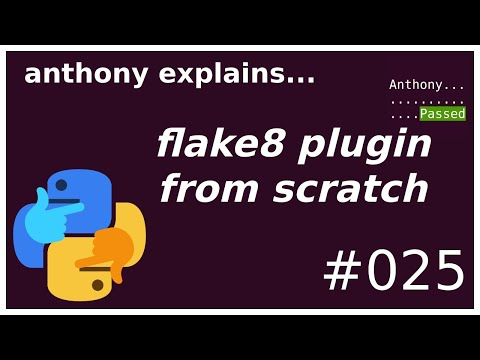

In [11]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="ot5Z4KQPBL8", width=560, height=315)

For convenience, I implemted this method called `analyse` that can also be used programmatically to find and display all errors found.

In [14]:
from typing import Optional

def analyse(
    tree: ast.AST, lines: Sequence[str], var_set: Optional[Variables] = None
) -> Errors:
    """Statically analyze the given tree using Hoare logic and return any
    errors found"""
    if not var_set:
        var_set = collect_all_variables(tree)
    hoare = Hoare(lines, var_set)
    hoare.visit(tree)
    return hoare.errors

code = """
def foo(x, y):  # flow: Low, High
    y = 3 * x
    return y
"""

tree = ast.parse(code)
errors = analyse(tree, code.split("\n"))

print(errors)

[(2, 0, "STA101 Information flow from low variable 'x' to high variable 'y' in function 'foo'")]


Finally, the plugin is defined in `staticinflowanalysis/plugin.py` and contains the plugin class that is used by flake8.

In [ ]:
# Core Library modules
import ast
import sys
from typing import Any, Generator, Tuple, Type, Sequence

if sys.version_info < (3, 8):
    # Third party modules
    import importlib_metadata
else:
    import importlib.metadata as importlib_metadata

# First party modules
from staticinflowanalysis.hoare import analyse


class Plugin:

    name = 'flake8_staticinflowanalysis'
    version = importlib_metadata.version(name)

    def __init__(self, tree: ast.AST, lines: Sequence[str]):
        self._tree = tree
        self._lines = lines

    def run(self) -> Generator[Tuple[int, int, str, Type[Any]], None, None]:
        errors = analyse(self._tree, self._lines)

        for line, col, msg in errors:
            yield line, col, msg, type(self)

To run this plugin in flake8, you have follow the install directions above and if everything works out, the following line should be executed and display the same errors as displayed in the install section

In [15]:
!flake8 test_code.py

test_code.py:1:1: STA101 Information flow from low variable 'a_long_variable_name' to high variable 'y' in function 'foo'
test_code.py:1:1: STA101 Information flow from low variable 'a_long_variable_name' to high variable 'z' in function 'foo'
test_code.py:8:1: STA101 Information flow from low variable 'x' to high variable 'y' in function 'bar'
test_code.py:8:1: STA301 Information flow from low variable 'x' to local high variable 'c' in function 'bar'
test_code.py:17:5: STA101 Information flow from low variable 'y' to high variable 'z' in inner function 'foobar'


# References

  - Torben Amtoft, Anindya Banerjee: 
    [A logic for information flow analysis with an application to forward slicing of simple imperative programs](https://doi.org/10.1016/j.scico.2006.03.002)
    
  - Prof. Dr. Jan Reineke: Lecture Notes for Program Analysis (Winter term 2020/2021), Saarland University
  
  - Andreas Zeller: [The Debugging Book, Tools and Techniques for Automated Software Debugging](https://www.debuggingbook.org)
  
  - [Flake8 plugin tutorial by Martin Thoma](https://medium.com/analytics-vidhya/how-to-write-flake8-plugins-5c5c47faffc2)